# Multi Layer Perceptrons
This notebook explores Multi Layer Perceptrons' explainability for Heart Disease Prediction using SHAP values.

In [5]:
# Enable autoreload for imports
%load_ext autoreload
%autoreload 2

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import shap

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score,f1_score

from config import config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Load the datasets
train_data = pd.read_csv(config.datapath / Path("train_data.csv"))
test_data = pd.read_csv(config.datapath / Path("test_data.csv"))

In [7]:
# Establish training and testing sets and target variable
X_train = train_data.drop(columns=["HeartDisease"])
y_train = train_data["HeartDisease"]
X_test = test_data.drop(columns=["HeartDisease"])
y_test = test_data["HeartDisease"]

# Data preprocessing and training of Logistic Lasso Regression

In [8]:
# Get numerical columns
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# KNN Imputation for missing values
imputer = KNNImputer()
X_train_imp = X_train.copy()
X_test_imp = X_test.copy()
X_train_imp[numerical_cols] = imputer.fit_transform(X_train[numerical_cols])
X_test_imp[numerical_cols] = imputer.transform(X_test[numerical_cols])

# Standard scaling
scaler = StandardScaler()
X_train_scaled = X_train_imp.copy()
X_test_scaled = X_test_imp.copy()
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train_imp[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test_imp[numerical_cols])

# Train MLP classifier

mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # Two hidden layers with 100 and 50 neurons
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)
mlp_model.fit(X_train_scaled, y_train)

# Predict and print classification report
y_pred = mlp_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Calculate and print balanced accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy: {balanced_acc:.4f}")

# Calculate and print F1-score
f1 = f1_score(y_test, y_pred)
print(f"\nF1 Score: {f1:.4f}")

              precision    recall  f1-score   support

           0       0.76      0.65      0.70        74
           1       0.79      0.86      0.82       110

    accuracy                           0.78       184
   macro avg       0.77      0.76      0.76       184
weighted avg       0.78      0.78      0.77       184


Balanced Accuracy: 0.7561

F1 Score: 0.8225


In [9]:
explainer = shap.KernelExplainer(mlp_model.predict_proba, X_train_scaled)

Using 734 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [10]:
shap_values = explainer.shap_values(X_test_scaled)

100%|██████████| 184/184 [07:30<00:00,  2.45s/it]


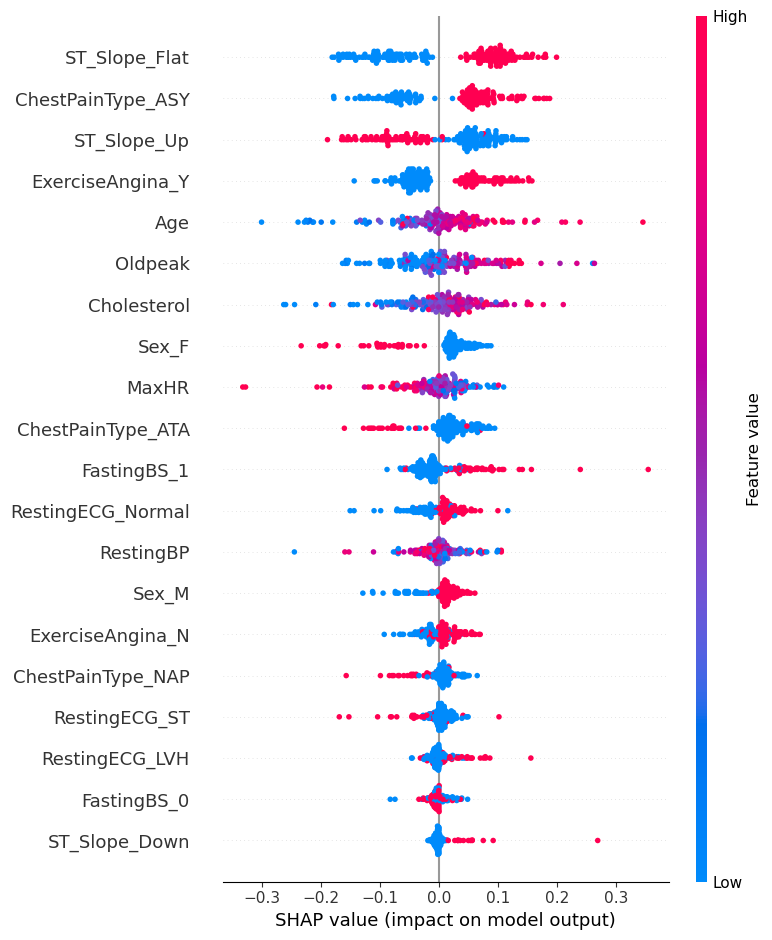

In [11]:
shap.summary_plot(shap_values[:, :, 1], X_test_scaled, feature_names=X_test_scaled.columns)

True Positive


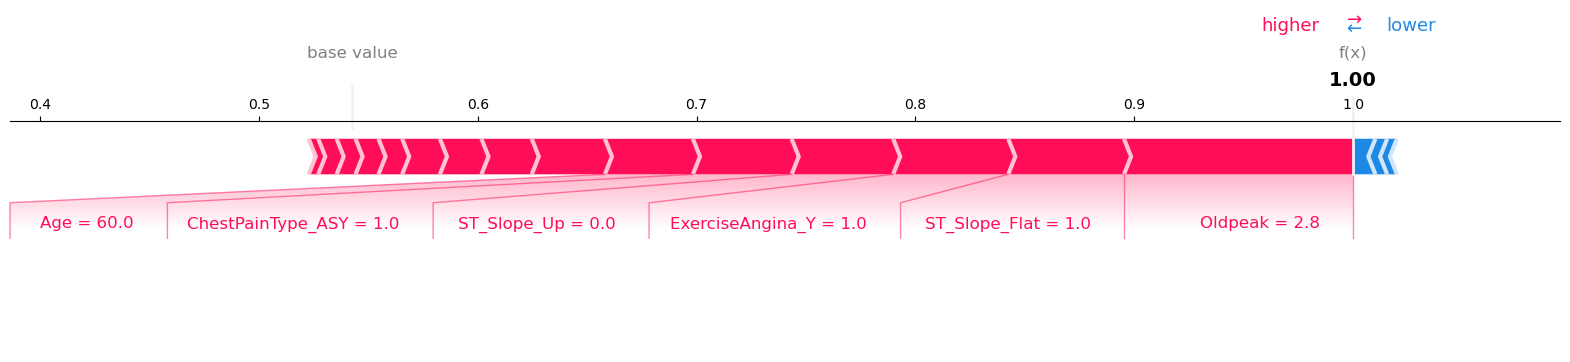

False Positive


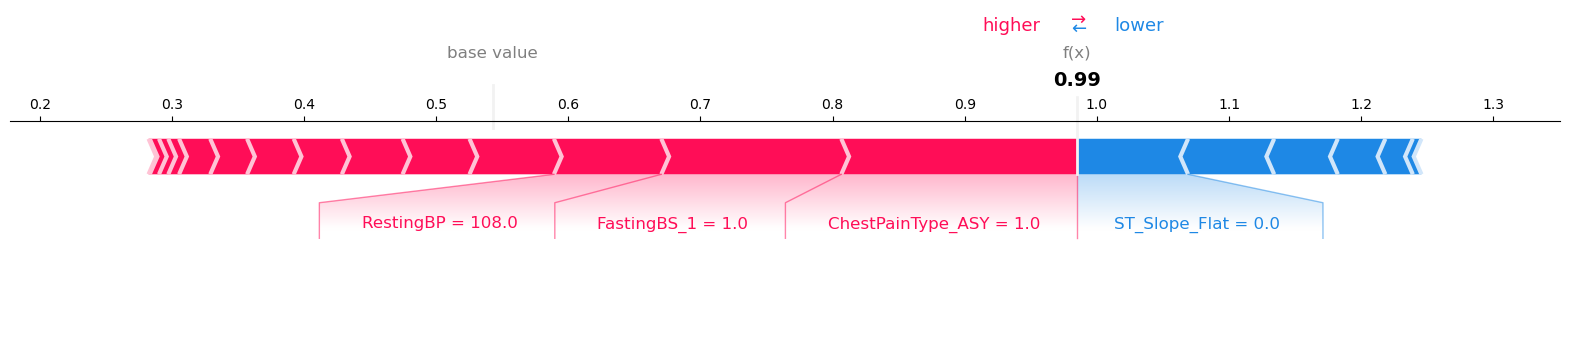

True Negative


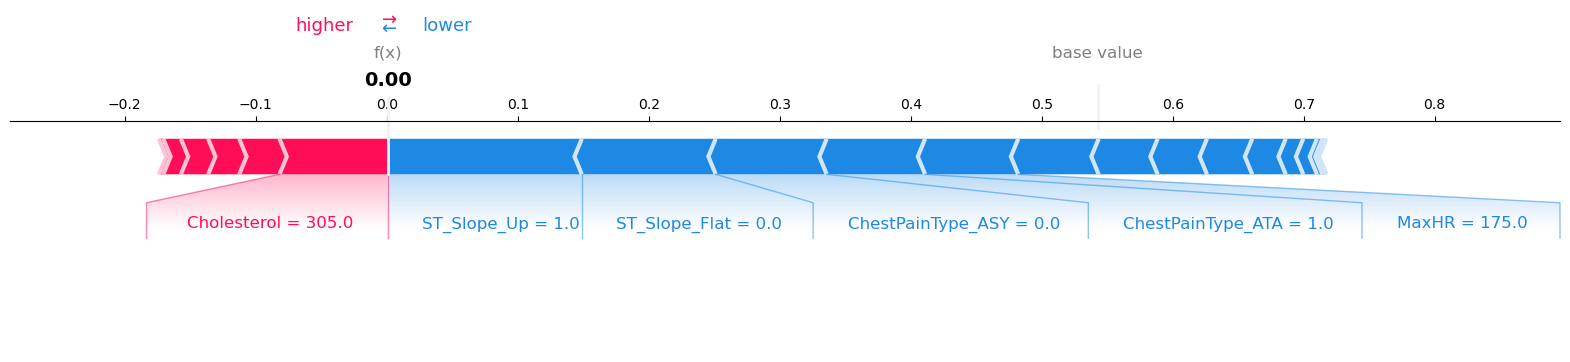

False Negative


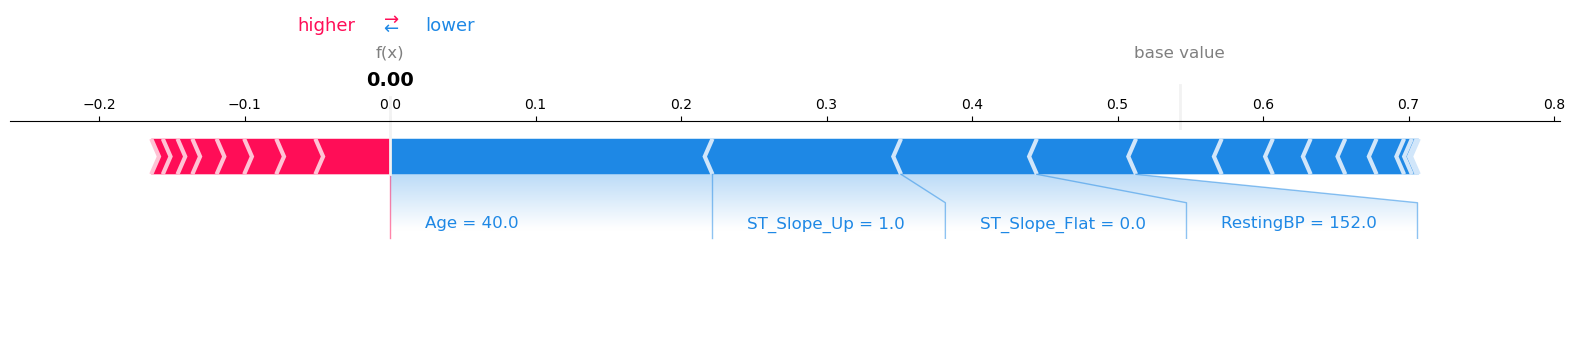

In [58]:
# Find indices for each prediction category
true_positives = (y_test == 1) & (y_pred == 1)
false_positives = (y_test == 0) & (y_pred == 1)
true_negatives = (y_test == 0) & (y_pred == 0)
false_negatives = (y_test == 1) & (y_pred == 0)

# Get first index from each category
tp_idx = y_test[true_positives].index[0]
fp_idx = y_test[false_positives].index[0]
tn_idx = y_test[true_negatives].index[0]
fn_idx = y_test[false_negatives].index[0]


# True Positive
print("True Positive")
shap.force_plot(explainer.expected_value[1], 
                shap_values[tp_idx, :, 1], 
                X_test.iloc[tp_idx],
                matplotlib=True,
                contribution_threshold=0.1,
                show=False)
plt.show()

# False Positive
print("False Positive")
shap.force_plot(explainer.expected_value[1], 
                shap_values[fp_idx, :, 1], 
                X_test.iloc[fp_idx],
                matplotlib=True,
                contribution_threshold=0.1,
                show=False)
plt.show()

# True Negative
print("True Negative")
shap.force_plot(explainer.expected_value[1], 
                shap_values[tn_idx, :, 1], 
                X_test.iloc[tn_idx],
                matplotlib=True,
                contribution_threshold=0.1,
                show=False)
plt.show()

# False Negative
print("False Negative")
shap.force_plot(explainer.expected_value[1], 
                shap_values[fn_idx, :, 1], 
                X_test.iloc[fn_idx],
                matplotlib=True,
                contribution_threshold=0.1,
                show=False)
plt.show()